# Age and Gender Prediction with Computer Vision

Train and evaluate a CNN for age (regression) and gender (classification) prediction on [DATASET NAME]. Achieves 5.57% MAE for age and 91.2% accuracy for gender on the test set.

- Dataset: [Link to dataset] (License: …)

---

## Table of Contents
1. Setup
2. Dataset and Preprocessing
3. Model
4. Training
5. Evaluation
6. Results and Visualizations
7. Error Analysis
8. Limitations and Responsible Use
9. Reproducibility
10. References

## Setting Up: Mount the google drive
Mount your google drive to the notebook. Also don't forget to **enable GPU** before your training.


In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Visualize a Few Photos

Before training, it's important to inspect your dataset and verify the labels. Below, we display a random sample of 20 face images from the dataset, each annotated with its age and gender. This helps confirm the data quality and label correctness, and gives a quick overview of the diversity present in the dataset.

Each image is shown with:
- **Age** (extracted from the filename)
- **Gender** (0: Male, 1: Female)

This visual check ensures the dataset is ready for model training.

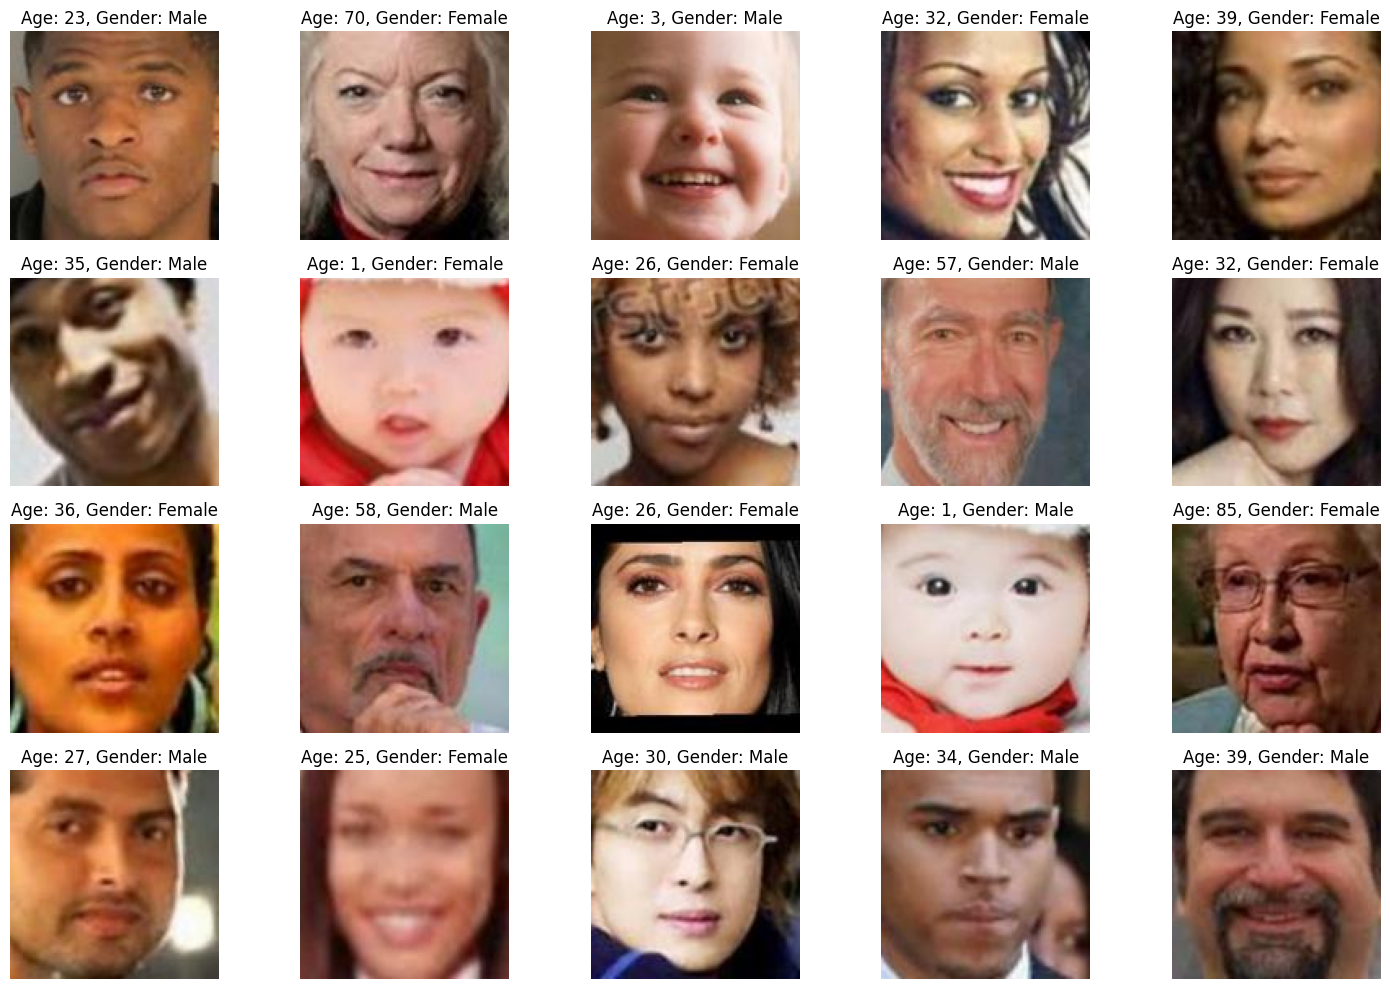

In [2]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Folder containing the images
folder_train_val = "/content/drive/My Drive/train_val"

# Get the list of image files
all_image_files = [file for file in os.listdir(folder_train_val) if file.lower().endswith(('.jpg'))]

# Shuffle the dataset to ensure random distribution
random.seed(0)  # Ensure reproducibility
random.shuffle(all_image_files)

# Function to load images and labels (age, gender)
def load_images_and_labels(dataset_path, filenames):
    images = []
    age_labels = []
    gender_labels = []
    for current_file_name in filenames:
        img = cv2.imread(os.path.join(dataset_path, current_file_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert color format from BGR to RGB
        labels = current_file_name.split('_')
        age_label = int(labels[0])
        gender_label = int(labels[1])
        age_labels.append(age_label)
        gender_labels.append(gender_label)
        images.append(img)

    # Convert lists to NumPy arrays
    images = np.array(images)
    age_labels = np.array(age_labels)
    gender_labels = np.array(gender_labels)

    return images, age_labels, gender_labels

# Load a random sample of 20 images
sample_images = all_image_files[:20]
train_images, train_age, train_gender = load_images_and_labels(folder_train_val, sample_images)

# Plot the images with their corresponding age and gender labels
plt.figure(figsize=(15, 10))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(train_images[i])
    plt.axis('off')


    gender_str = 'Male' if train_gender[i] == 0 else 'Female'  # 0 is Male and 1 is Female
    plt.title(f"Age: {train_age[i]}, Gender: {gender_str}")

plt.tight_layout()
plt.show()

## Step 1: Data Pre-Processing

Before training the CNN, we prepared the dataset with the following steps:

1. **Splitting:**  
   The image files were randomly shuffled and split into training (80%) and validation (20%) sets to ensure unbiased evaluation.

2. **Loading & Normalization:**  
   Images were loaded from disk, and pixel values were rescaled from [0, 255] to [0, 1] for better model convergence. Age and gender labels were extracted directly from the filenames.

3. **Data Augmentation:**  
   Random horizontal flips were applied during training to increase data diversity and help the model generalize better.

This pre-processing ensures the model receives clean, normalized, and varied data for robust learning.

In [3]:
import os
import random
import numpy as np

folder_train_val = "/content/drive/My Drive/train_val"
all_image_files = [file for file in os.listdir(folder_train_val) if file.lower().endswith(('.jpg'))]

# Shuffle the dataset to ensure random distribution
random.seed(0)  # Ensure reproducibility
random.shuffle(all_image_files)

# Calculate the number of images for each set
n_train_val = len(all_image_files)
train_end = int(n_train_val * 0.8)

# Split the dataset
train_image_files = all_image_files[:train_end]
val_image_files = all_image_files[train_end:]
print(f"Number of images for training: {len(train_image_files)}")
print(f"Number of images for validation: {len(val_image_files)}")

def load_imgs_lables(dataset_path,filenames):
  print('load all image data, age and gender labels...')
  images = []
  age_labels = []
  gender_labels = []
  for current_file_name in filenames:
    img = cv2.imread(os.path.join(dataset_path, current_file_name))
    img = img / 255.0  # Normalize pixel values

    labels = current_file_name.split('_')
    age_label = int(labels[0])
    gender_label = int(labels[1])
    age_labels.append(age_label)
    gender_labels.append(gender_label)
    images.append(img)

  # Convert to NumPy arrays
  images = np.array(images)
  age_labels = np.array(age_labels)
  gender_labels = np.array(gender_labels)
  return images, age_labels, gender_labels

# load data from the training set
train_images, train_age, train_gender = load_imgs_lables(folder_train_val,train_image_files)

# load data from the validation set
val_images, val_age, val_gender = load_imgs_lables(folder_train_val,val_image_files)

Number of images for training: 4000
Number of images for validation: 1000
load all image data, age and gender labels...
load all image data, age and gender labels...


## STEP 2: Build CNN Network

We constructed a custom CNN model for joint age estimation and gender classification from face images. The model processes inputs of shape **128 x 128 x 3** and outputs:
- **Gender:** Binary classification (single sigmoid unit)
- **Age:** Regression (single linear unit)

**Model Highlights:**
- **Data Augmentation:** Random horizontal flips are applied to improve generalization.
- **Channel Compression:** The first layer compresses color channels, reducing dimensionality and normalizing input.
- **Convolutional Blocks:** Four blocks with increasing filter sizes (64, 128, 256, 512), each followed by batch normalization, activation, max pooling, and dropout for regularization.
- **Dense Head:** Flattened features pass through three dense layers with various activations and dropout to further prevent overfitting.
- **Outputs:** Two branches—one for gender (sigmoid) and one for age (linear).

The architecture is summarized with `modelA.summary()` and visualized using `plot_model()`.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_flip (RandomFlip)  │ (None, 128, 128, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 1)    │              4 │ random_flip[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 1)    │              4 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │            640 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 64, 64)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 64, 64, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32, 32, 128)    │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 256)    │          1,024 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)       

 Total params: 18,499,722 (70.57 MB)

 Trainable params: 18,496,008 (70.56 MB)

 Non-trainable params: 3,714 (14.51 KB)

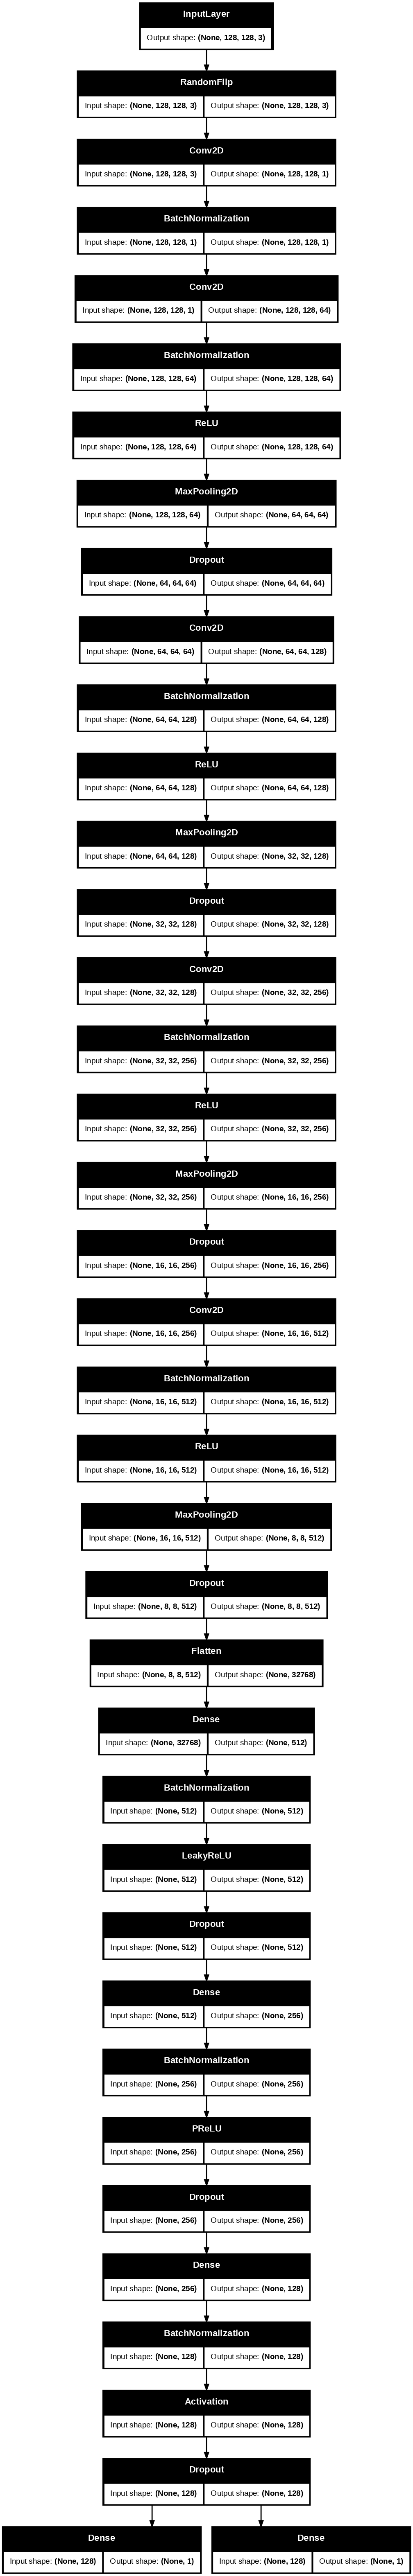

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_model():
    # Input Layer following the shape requirements
    inputs = layers.Input(shape=(128, 128, 3))

    # Data Augmentation
    x = layers.RandomFlip(mode='horizontal')(inputs)

    # Compress all the colors channel into one (maybe grayscal channel represent all channels combined)
    # The best part is that it reduce dimentionality and normalize channel of each color with learnable weight and bias
    x = layers.Conv2D(1, (1, 1), kernel_initializer='HeNormal', use_bias=True)(x)

    # Conv Block 1
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='HeNormal', use_bias=True)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.1)(x)

    # Conv Block 2
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='HeNormal', use_bias=True)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.15)(x)

    # Conv Block 3
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='HeNormal', use_bias=True)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.2)(x)

    # Conv Block 4
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='HeNormal', use_bias=True)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)

    # Dense Head
    x = layers.Flatten()(x)
    x = layers.Dense(512, kernel_initializer='HeNormal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(256, kernel_initializer='HeNormal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.PReLU()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(128, kernel_initializer='HeNormal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('selu')(x)
    x = layers.Dropout(0.1)(x)

    # Outputs
    gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(x)
    age_output = layers.Dense(1, activation='linear', name='age_output')(x)

    # Create model
    model = Model(inputs=inputs, outputs=[gender_output, age_output])
    return model

modelA = build_model()
modelA.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelA, show_shapes=True,dpi=100)

## STEP 3: Compile and train model

## Model Compilation

The model is compiled using the Adam optimizer with a learning rate of 0.01.  
- **Loss functions:** Binary cross-entropy for gender classification and mean squared error for age regression.
- **Loss weights:** Gender loss is weighted higher to balance the two tasks.
- **Metrics:** Accuracy for gender and MAE for age are tracked during training.

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
modelA.compile(
    optimizer=optimizer,
    loss={
        'gender_output': 'binary_crossentropy',
        'age_output': 'mean_squared_error',
    },
    loss_weights={
        'age_output': 1,
        'gender_output': 10
    },
    metrics={
        'gender_output': ['accuracy'],
        'age_output': ['mae']
    }
)

## Training and Callbacks

Training uses several callbacks to improve efficiency and model quality:
- **EarlyStopping:** Stops training if validation loss does not improve for 50 epochs and restores the best weights.
- **ReduceLROnPlateau:** Dynamically reduces the learning rate when loss plateaus, using different factors and patience values for both training and validation loss.

The model is trained for up to 300 epochs with a batch size of 64, and both the trained model and training history are saved for later analysis.

In [ ]:
# callbacks customized to speed up learning without minimalistic trad off the learning quality
# restor the best weights acheived by monitoring validation loss then stop after 50 tries
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=50,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="loss",  # Track loss
        factor=0.98,  # Reduce learning rate by multiply the factor (soft penalty)
        patience=1,  # Wait for 1 epochs without improvement before reducing LR
        min_lr=1e-6,  # Minimum learning rate to prevent it from getting too small
        verbose=1  # Print messages when LR changes
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="loss",
        factor=0.95,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="loss",
        factor=0.8,
        patience=7,
        min_lr=1e-6,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=20,
        min_lr=1e-6,
        verbose=1 
    )
]

historyA = modelA.fit(
    train_images,{'age_output': train_age, 'gender_output': train_gender},
    epochs=300,
    validation_data=(val_images, {'age_output': val_age, 'gender_output': val_gender}),
    batch_size=64,
    callbacks=callbacks
)

# save model
modelA.save('age_gender_A.keras')
# save history
import pickle
with open('train_historyA.pkl', 'wb') as f:
    pickle.dump(historyA.history, f)

Epoch 1/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 408ms/step - age_output_loss: 1074.7412 - age_output_mae: 26.9904 - gender_output_accuracy: 0.5589 - gender_output_loss: 0.7554 - loss: 1082.4154 - val_age_output_loss: 20337.3672 - val_age_output_mae: 122.3351 - val_gender_output_accuracy: 0.4960 - val_gender_output_loss: 7.5259 - val_loss: 20496.4199 - learning_rate: 0.0100
Epoch 2/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - age_output_loss: 213.4453 - age_output_mae: 11.0689 - gender_output_accuracy: 0.6303 - gender_output_loss: 0.6742 - loss: 220.1604 - val_age_output_loss: 2426.6636 - val_age_output_mae: 41.1391 - val_gender_output_accuracy: 0.6270 - val_gender_output_loss: 0.8731 - val_loss: 2429.2896 - learning_rate: 0.0100
Epoch 3/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - age_output_loss: 146.9458 - age_output_mae: 9.2151 - gender_output_accuracy: 0.6290 - gender_output_loss: 0.6749 - loss: 153.6825 - val_age_output_loss: 1017.5963 - val_age_output_mae: 27.7861 - val_gender_ou

## Validation Results

After evaluating the model on the validation set, the following metrics were obtained:

- **Total loss:** 65.50
- **Gender classification loss:** 0.32
- **Age estimation loss:** 62.87
- **Age estimation MAE:** 5.57
- **Gender classification accuracy:** 91.2%

These results indicate the model's performance for both age estimation and gender classification tasks.

In [ ]:
modelA.evaluate(val_images, {'age_output': val_age, 'gender_output': val_gender})

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - age_output_loss: 65.1395 - age_output_mae: 5.6209 - gender_output_accuracy: 0.9238 - gender_output_loss: 0.2567 - loss: 67.6728


[65.50276947021484,
 0.31994691491127014,
 62.865509033203125,
 5.571743011474609,
 0.9120000004768372]

## STEP 4: Draw the learning curves
The four learning curve figures for model A as follows.
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

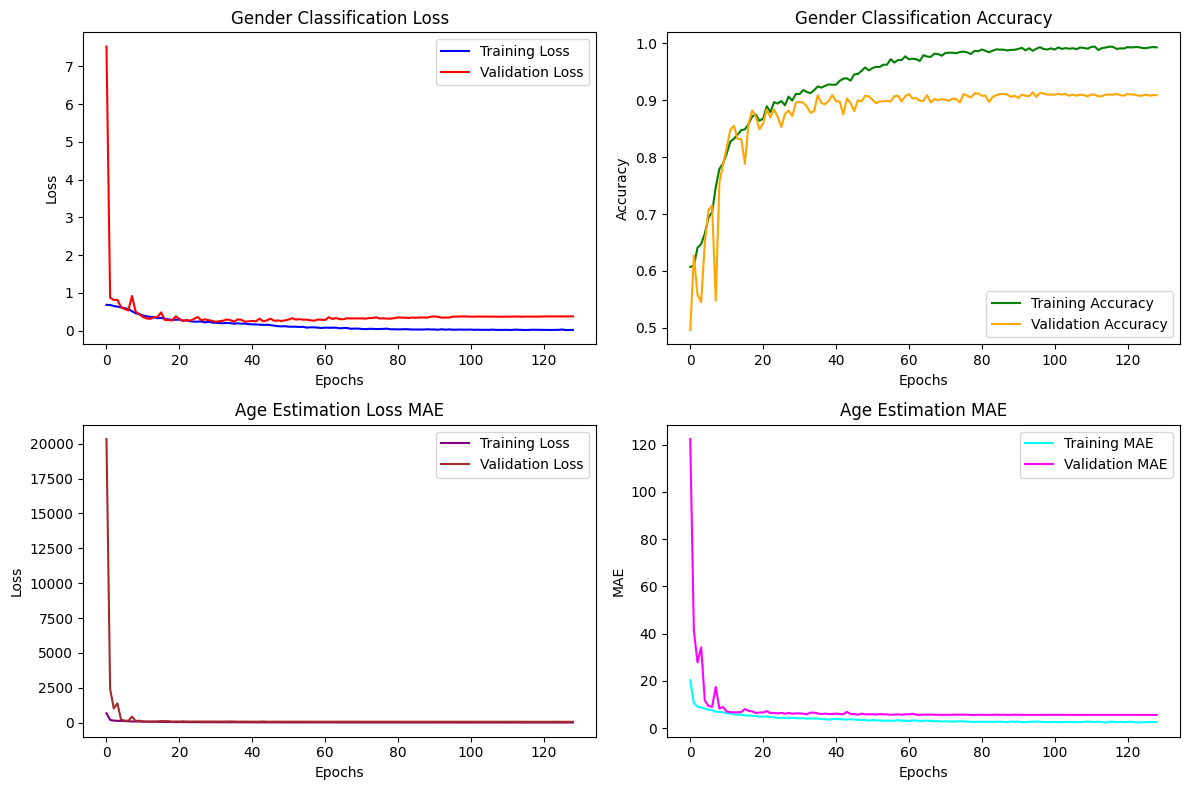

In [ ]:
import pickle
with open('train_history.pkl', 'rb') as f:
    history_dict = pickle.load(f)

import matplotlib.pyplot as plt

# Plot the loss for gender classification
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history_dict['gender_output_loss'], label='Training Loss', color='blue')
plt.plot(history_dict['val_gender_output_loss'], label='Validation Loss', color='red')
plt.title('Gender Classification Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy for gender classification
plt.subplot(2, 2, 2)
plt.plot(history_dict['gender_output_accuracy'], label='Training Accuracy', color='green')
plt.plot(history_dict['val_gender_output_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Gender Classification Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot the loss for age estimation
plt.subplot(2, 2, 3)
plt.plot(history_dict['age_output_loss'], label='Training Loss', color='purple')
plt.plot(history_dict['val_age_output_loss'], label='Validation Loss', color='brown')
plt.title('Age Estimation Loss MAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the MAE for age estimation
plt.subplot(2, 2, 4)
plt.plot(history_dict['age_output_mae'], label='Training MAE', color='cyan')
plt.plot(history_dict['val_age_output_mae'], label='Validation MAE', color='magenta')
plt.title('Age Estimation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Adjust layout to prevent overlapping of plots
plt.tight_layout()

# Show the plots
plt.show()

## Learning Curves

The following plots illustrate the training progress and model performance on a focused scale:

1. **Gender Classification Loss:** Training and validation loss curves (y-axis: 0–1).
2. **Gender Classification Accuracy:** Training and validation accuracy curves (y-axis: 80%–100%).
3. **Age Estimation Loss (MSE):** Training and validation loss curves (y-axis: 0–200).
4. **Age Estimation MAE:** Training and validation MAE curves (y-axis: 0–20).
5. **Learning Rate Curve:** Shows how the learning rate changes throughout training.

These curves help visualize convergence, generalization, and the effect of learning rate scheduling.

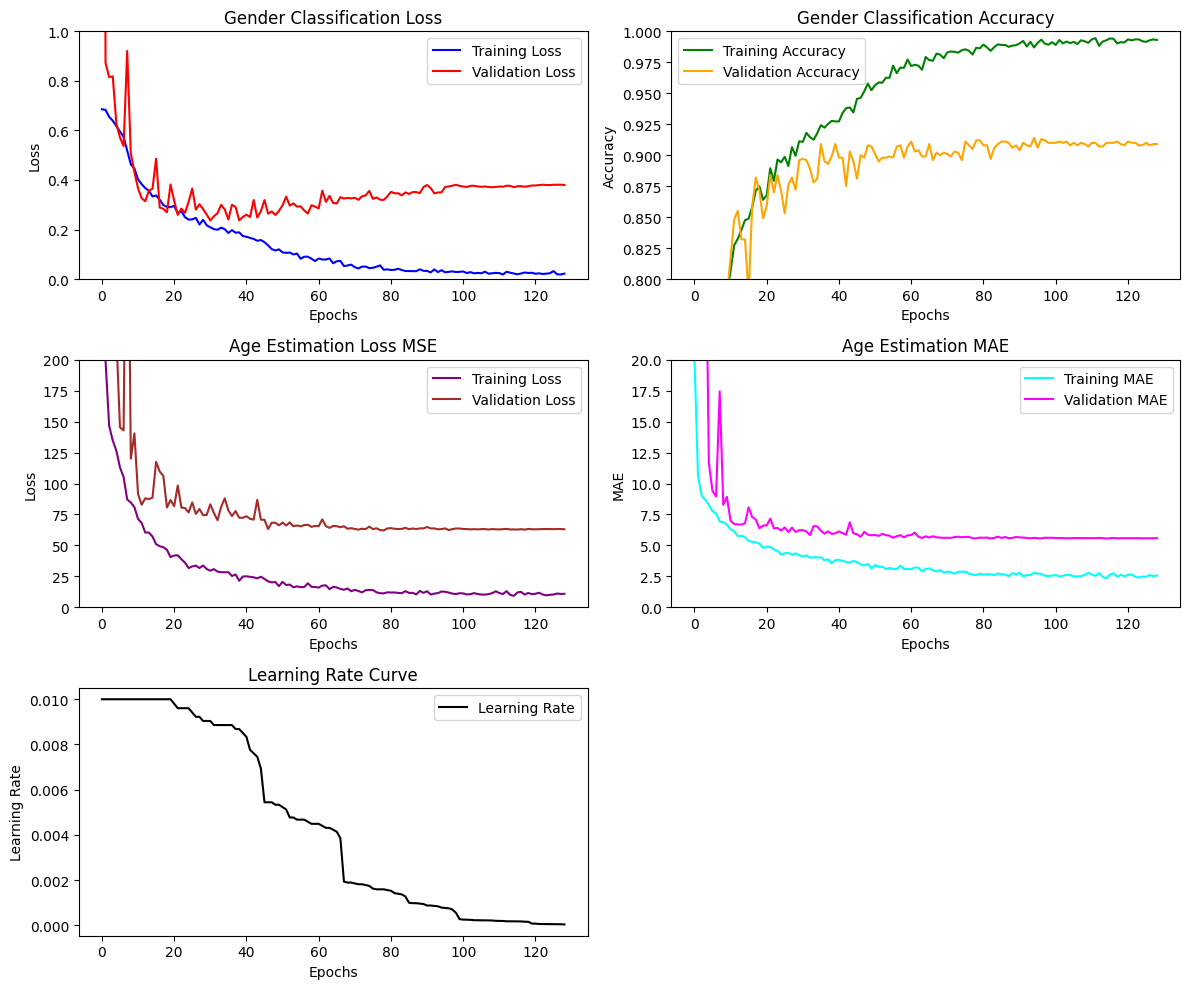

In [ ]:
# Draw the curve learns with the focus on important intervals for each plot, also addictional learning rate curve added

import pickle
import matplotlib.pyplot as plt

# Load history from pickle file
with open('train_history.pkl', 'rb') as f:
    history_dict = pickle.load(f)

# Create a figure with 3 rows and 2 columns
plt.figure(figsize=(12, 10))

# Subplot 1: Gender Classification Loss (y-axis between 0 and 1)
plt.subplot(3, 2, 1)
plt.plot(history_dict['gender_output_loss'], label='Training Loss', color='blue')
plt.plot(history_dict['val_gender_output_loss'], label='Validation Loss', color='red')
plt.title('Gender Classification Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()

# Subplot 2: Gender Classification Accuracy (y-axis between 80% and 100%)
plt.subplot(3, 2, 2)
plt.plot(history_dict['gender_output_accuracy'], label='Training Accuracy', color='green')
plt.plot(history_dict['val_gender_output_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Gender Classification Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)
plt.legend()

# Subplot 3: Age Estimation Loss (y-axis between 0 and 200)
plt.subplot(3, 2, 3)
plt.plot(history_dict['age_output_loss'], label='Training Loss', color='purple')
plt.plot(history_dict['val_age_output_loss'], label='Validation Loss', color='brown')
plt.title('Age Estimation Loss MSE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 200)
plt.legend()

# Subplot 4: Age Estimation MAE (y-axis between 0 and 20)
plt.subplot(3, 2, 4)
plt.plot(history_dict['age_output_mae'], label='Training MAE', color='cyan')
plt.plot(history_dict['val_age_output_mae'], label='Validation MAE', color='magenta')
plt.title('Age Estimation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.ylim(0, 20)
plt.legend()

# Subplot 5: Learning Rate Curve
plt.subplot(3, 2, 5)
plt.plot(history_dict['learning_rate'], label='Learning Rate', color='black')
plt.title('Learning Rate Curve')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()

# Adjust layout to prevent overlapping of plots
plt.tight_layout()

# Display the plots
plt.show()
